In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
import logging
import hydra
from matplotlib import pyplot as plt
from scipy.fft import fft2
import numpy as np
import xarray
import gnss_tid.plotting
plt.style.use("bmh")

with hydra.initialize(version_base=None, config_path="src/gnss_tid/conf", job_name="jupyter"):
    cfg = hydra.compose(config_name="config")
logging.basicConfig(level=logging.INFO)
cfg.focus.n_jobs = 1
logging.info("%s", cfg.focus.n_jobs)
points = hydra.utils.instantiate(cfg.event.pointdata)
focuser = hydra.utils.instantiate(cfg.focus)


INFO:root:1


In [51]:
slices, time = points.get_time_slices(cfg.sample.window, cfg.sample.step)
ii = -4
data = focuser.process_heights(points, slices[ii])
patches = focuser.process_patches(data).expand_dims(time=[time[ii]])

INFO:gnss_tid.spectral:[210-214]: height = 150.0
INFO:gnss_tid.spectral:[210-214]: height = 160.0
INFO:gnss_tid.spectral:[210-214]: height = 170.0
INFO:gnss_tid.spectral:[210-214]: height = 180.0
INFO:gnss_tid.spectral:[210-214]: height = 190.0
INFO:gnss_tid.spectral:[210-214]: height = 200.0
INFO:gnss_tid.spectral:[210-214]: height = 210.0
INFO:gnss_tid.spectral:[210-214]: height = 220.0
INFO:gnss_tid.spectral:[210-214]: height = 230.0
INFO:gnss_tid.spectral:[210-214]: height = 240.0
INFO:gnss_tid.spectral:[210-214]: height = 250.0
INFO:gnss_tid.spectral:[210-214]: height = 260.0
INFO:gnss_tid.spectral:[210-214]: height = 270.0
INFO:gnss_tid.spectral:[210-214]: height = 280.0
INFO:gnss_tid.spectral:[210-214]: height = 290.0
INFO:gnss_tid.spectral:[210-214]: height = 300.0
INFO:gnss_tid.spectral:[210-214]: height = 310.0
INFO:gnss_tid.spectral:[210-214]: height = 320.0
INFO:gnss_tid.spectral:[210-214]: height = 330.0
INFO:gnss_tid.spectral:[210-214]: height = 340.0
INFO:gnss_tid.spectr

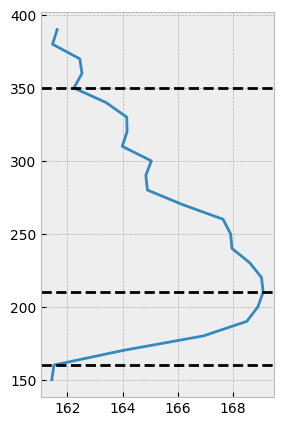

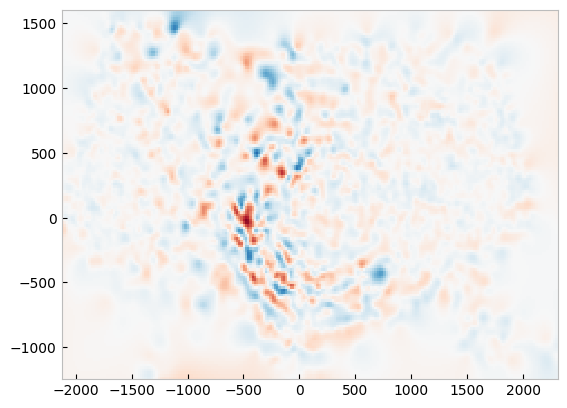

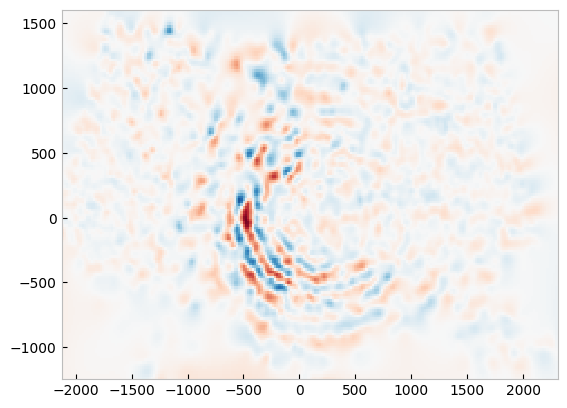

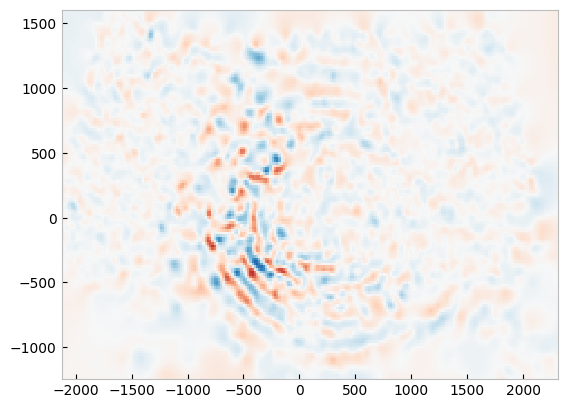

In [60]:
H = [160, 210, 350]
plt.figure(figsize=(3, 5))
plt.plot(patches.isel(time=0).objective, patches.height)
for h in H:
    plt.axhline(h, linestyle="--", color="k")

for i, height in enumerate(H):
    plt.figure()
    data.image.sel(height=height).plot(vmax=.5, add_colorbar=False, add_labels=False)

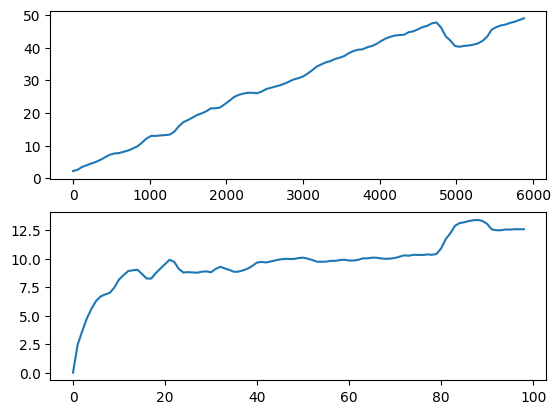

In [2]:
import xarray
import numpy as np
from matplotlib import pyplot as plt
data = xarray.open_dataset("outputs/2024-12-06/22-20-41/autofocus.h5")
t = data.phase.time
c = np.unwrap(data.phase)
c = c.max() - c
c = c[10:]
t = (t - t[0]).dt.total_seconds()[:-10]
# plt.plot(t / c)
x = t / c
A = 2 * np.pi / 60
fig, ax = plt.subplots(2, 1)
ax[0].plot(t, c)
ax[1].plot(A * x)

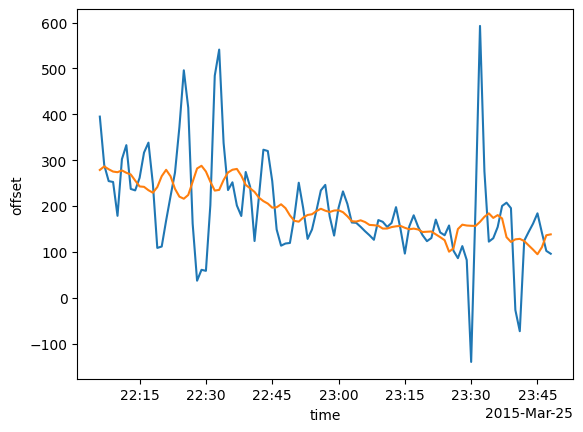

In [50]:
c = data.offset.isel(time=slice(6, None))
c = c.max() - c
# t = (c.time - c.time[0]).dt.total_seconds()
# x = 1000 * c / t
# fig, ax = plt.subplots(2, 1)
# ax[0].plot(t, c)
# ax[1].plot(x)
# print(t[1], c[1])
c *= 1000
c.differentiate("time", datetime_unit="s").plot()
c.differentiate("time", datetime_unit="s").rolling(time=11, min_periods=1, center=True).mean().plot()

(-200.0, 200.0)

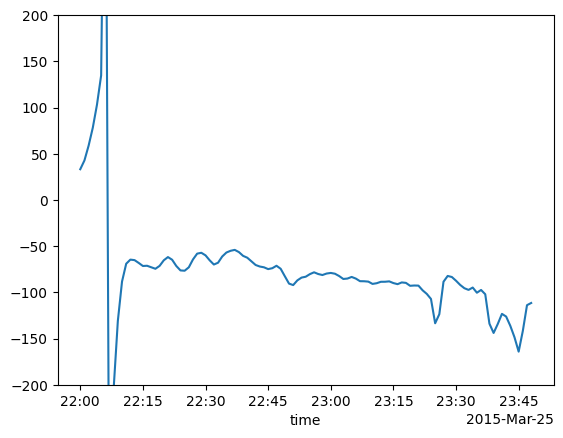

In [67]:
((2 * np.pi / (data.offset.differentiate("time", datetime_unit="s").rolling(time=11, min_periods=1, center=True).mean() / data.wavelength)) / 60).plot()
plt.ylim(-200, 200)

In [63]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

shapename = 'admin_1_states_provinces_lakes'
states_shp = shpreader.natural_earth(resolution='110m', category='cultural', name=shapename)

pd = points.get_data(slice(210, 214), 220)

p = pd.plot.scatter(
    x="lon",
    y="lat",
    hue="tec",
    subplot_kws=dict(projection=ccrs.Orthographic(-95, 35)),
    # subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
    transform=ccrs.PlateCarree(),
)
p.axes.add_feature(cfeature.STATES, edgecolor='black')
p.axes.coastlines()
p.axes.gridlines()
p.axes.set_extent([-120, -70, 21, 50], crs=ccrs.PlateCarree())

/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_1_states_provinces_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>

In [47]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec  9 09:29:41 2024

@author: mraks1
"""

import numpy as np
import pandas as pd
import h5py, os
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import signal
from scipy.interpolate import CubicSpline
plt.style.use("bmh")

#Vadas center = 36.75N, 94.85W, time = 23:15-23:22, Phi = 180, 190, 208
#Vadas: X = 100 W, 34 N: lambda_H = 259,66\pm8.2, tau_r=22.25\pm5.6min
#Vadas: Red Box, -106 -- -92, 32 - 40N. 

def tdft(y, dx, nfft=128, window='hann', scaling='spectrum'):
    
    def _cubicSplineFit(x):
        idf = np.isfinite(x)
        x0 = np.where(idf)[0]
        x1 = np.arange(x.size)
        CSp = CubicSpline(x0, x[idf])
        y = CSp(x1)
        return y
    
    fs = 1 / dx
    k_max = fs / 2
    dk = 2 * k_max / nfft
    k = np.round(np.arange(-k_max, k_max, dk), 5)
    k = k[int(nfft / 2):]
    
    if np.sum(np.isnan(y)) > 0:
        ix1 = np.where(np.isfinite(y))[0][0]
        ix2 = np.where(np.isfinite(y))[0][-1]
        y[ix1:ix2] = _cubicSplineFit(y[ix1:ix2])
    idf = np.isfinite(y)
    window_size = np.sum(idf)
    Stmp = np.fft.fft(y[idf] * signal.get_window(window, window_size), n=nfft)
    if scaling == 'spectrum':
        Sx = abs(Stmp[0:int(nfft / 2)]) ** 2 / window_size ** 2
    elif scaling == 'psd':
        Sx = abs(Stmp[0:int(nfft / 2)]) ** 2 / window_size * dx
    else:
        Sx = abs(Stmp[0:int(nfft / 2)]) ** 2

    return k, Sx

def tdftt(t, y, T=30, nfft=1024, Nw=240, Nskip=1, window='hann', scaling='spectrum'):
    def _cubicSplineFit(x):
        idf = np.isfinite(x)
        x0 = np.where(idf)[0]
        x1 = np.arange(x.size)
        CSp = CubicSpline(x0, x[idf])
        y = CSp(x1)
        return y
    
    Wn = signal.get_window(window, Nw)
    fs = 1 / T
    f_max = fs / 2
    df = 2 * f_max / nfft
    f = np.round(np.arange(-f_max, f_max, df), 5)
#    f = np.fft.fftfreq(nfft) # to mHz
    f = f[int(nfft / 2):]
    
    if np.sum(np.isnan(y)) > 0:
        y = _cubicSplineFit(y)
    
#    Treducted = t[:-Nw]
#    Tspecto = Treducted[::Nskip] + timedelta(seconds=Nw/2*T)
    
    Sx = np.nan * np.ones((t.size, int(nfft/2)))
    start = int(Nw / 2)
    for i in np.arange(0, y.shape[0] - Nw, Nskip):
        Stmp = np.fft.fft(y[i:i+Nw] * Wn, n=nfft)
        if scaling == 'spectrum':
            Sx[start+i, :] = abs(Stmp[0:int(nfft/2)])**2 / Nw**2
        elif scaling == 'psd':
            Sx[start+i, :] = abs(Stmp[0:int(nfft/2)])**2 / Nw * T
        else:
            Sx[start+i, :] = abs(Stmp[0:int(nfft/2)])**2
    return f, Sx

def get_line_coordinates(start_x, start_y, azimuth, distance):
    """Calculates the end coordinates of a line given the start coordinates, azimuth, and distance."""

    # Convert azimuth to radians
    azimuth_rad = np.radians(azimuth)

    # Calculate end coordinates
    end_x = start_x + distance * np.sin(azimuth_rad)
    end_y = start_y + distance * np.cos(azimuth_rad)

    return end_x, end_y

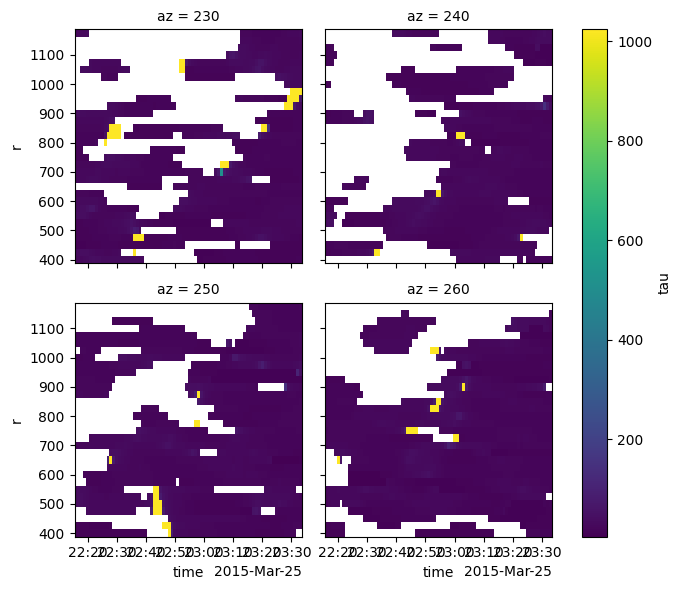

In [2]:
import xarray as xr
import gnss_tid.parameter
from datetime import datetime
import numpy as np

file = "outputs/2024-12-06/22-20-41/autofocus.h5"
data = xr.open_dataset(file)

x = data.x.values  # x coordinate in local cartesian system (km)
y = data.y.values  # y coordinate in local cartesian system (km)
cx0, cy0 = data.center.values[0], data.center.values[1]  # TID center
azimuth = [230, 240, 250, 260]
distance = np.arange(400, 1200, 25)
lines_x, lines_y = gnss_tid.parameter.get_line_coordinates(cx0, cy0, azimuth, distance)
lines_x = xr.DataArray(
    lines_x, coords={"r": distance, "az": azimuth}, dims=["r", "az"]
)
lines_y = xr.DataArray(
    lines_y, coords={"r": distance, "az": azimuth}, dims=["r", "az"]
)
lines_tec = data.image.interp(x=lines_x, y=lines_y)
q = gnss_tid.parameter.xr_estimate_period(lines_tec)
q.dropna("time", how="all").plot(col="az", col_wrap=2)

In [541]:
import gnss_tid.parameter
from xrscipy.signal import spectrogram
import matplotlib.pyplot as plt

s_thresh = .0005
minute_lines = lines_tec.assign_coords(time=np.arange(lines_tec.time.size))
Stt = spectrogram(minute_lines, dim="time", nperseg=30, nfft=128, noverlap=29, scaling="spectrum")
max_comp = Stt.isel(frequency=Stt.argmax("frequency"))
tau = (
    (1 / max_comp.frequency)
    .rename("tau")
    .where(max_comp > s_thresh)
    .reindex_like(minute_lines)
    .assign_coords(time=lines_tec.time)
)

L = 800
k_thresh = 0.0001
dx = 20
v = np.arange(-(L / 2) - dx / 2, (L / 2) + dx / 2, dx)
v = xr.DataArray(v, coords={"z": v}, dims=["z"])
tec_zonal = data.image.sel(x=lines_x, y=lines_y + v, method="nearest")
Sx = spectrogram(tec_zonal, dim="z", noverlap=0, nfft=1024, scaling="spectrum")
max_comp_x = Sx.isel(frequency=Sx.argmax("frequency")).isel(z=0).drop_vars("z")

tec_meridional = data.image.sel(x=lines_x + v, y=lines_y, method="nearest")
Sy = spectrogram(tec_meridional, dim="z", noverlap=0, nfft=1024, scaling="spectrum")
max_comp_y = Sy.isel(frequency=Sy.argmax("frequency")).isel(z=0).drop_vars("z")

kx = max_comp_x.frequency.where(max_comp_x > s_thresh, 0).where(lambda x: x > k_thresh, 0)
ky = max_comp_y.frequency.where(max_comp_y > s_thresh, 0).where(lambda x: x > k_thresh, 0)
k = np.hypot(kx, ky)
wavelength = (1 / k).rename("wavelength")
phase_speed = (wavelength * 1000 / (tau * 60)).rename("phase_speed")

Sr = spectrogram(lines_tec, dim="r", nperseg=16, nfft=16, noverlap=15)
max_comp_r = Sr.isel(frequency=Sr.argmax("frequency"))
kr = max_comp_r.frequency.where(max_comp_r > s_thresh, 0).where(lambda x: x > k_thresh, 0)
wavelength_r = (1 / kr).rename("wavelength")
phase_speed_r = (wavelength_r * 1000 / (tau * 60)).rename("phase_speed")

/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xrscipy/signal/spectral.py:308: UserWarning: nperseg = 256 is greater than input length  = 41, using nperseg = 41
  f, t, Pxy = _spectral_helper(
/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xrscipy/signal/spectral.py:308: UserWarning: nperseg = 256 is greater than input length  = 41, using nperseg = 41
  f, t, Pxy = _spectral_helper(


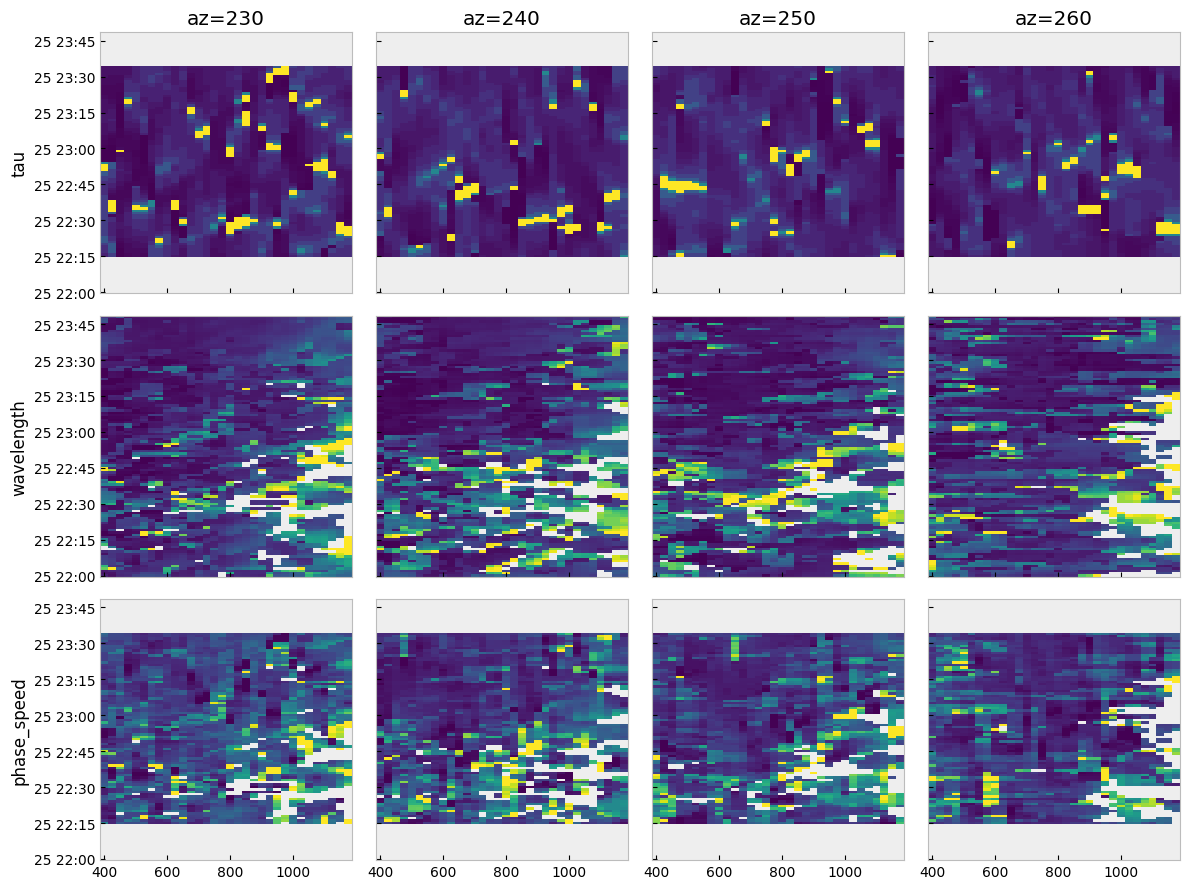

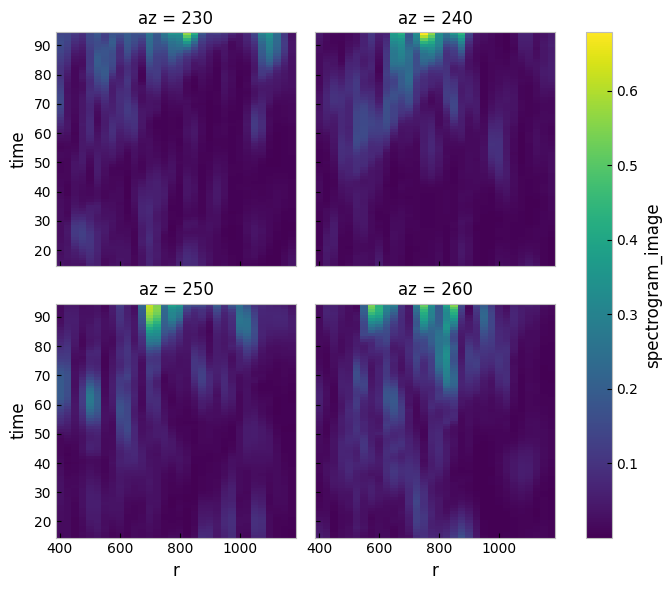

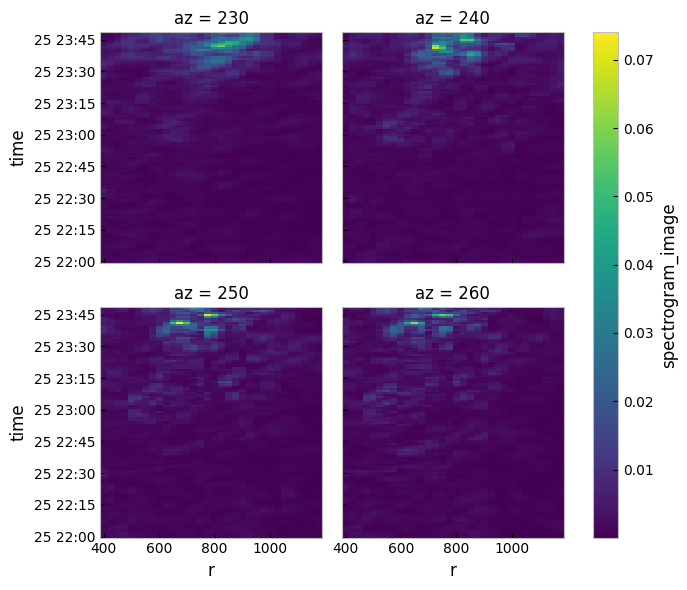

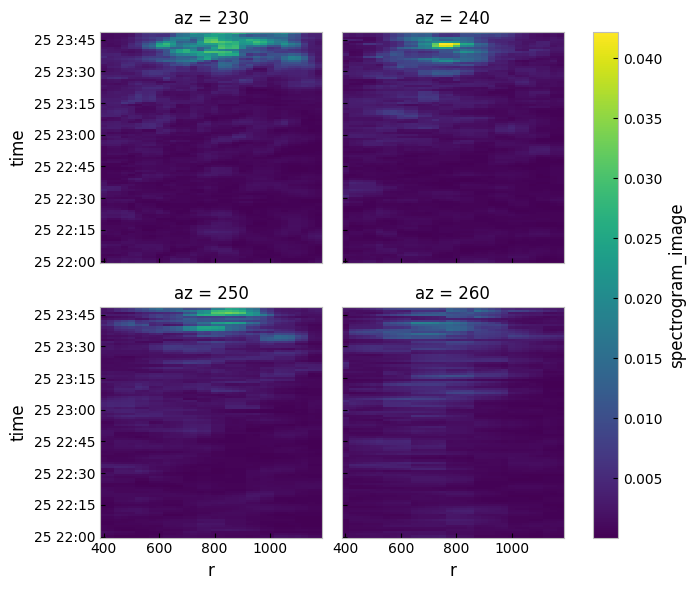

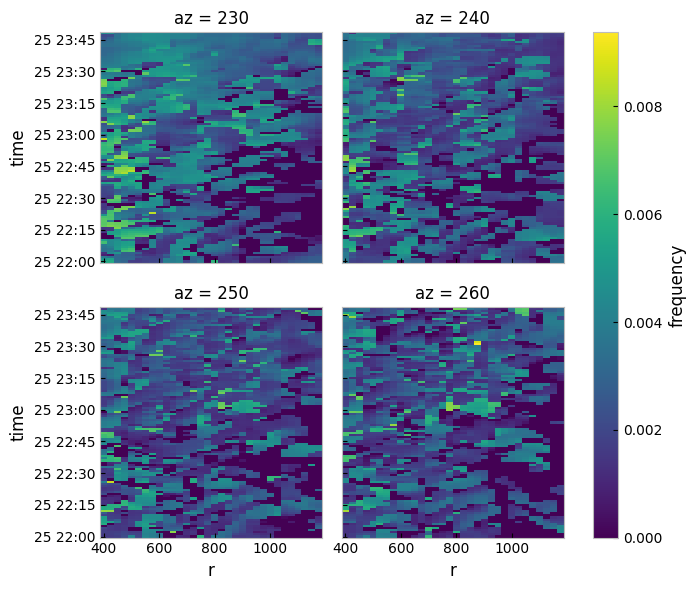

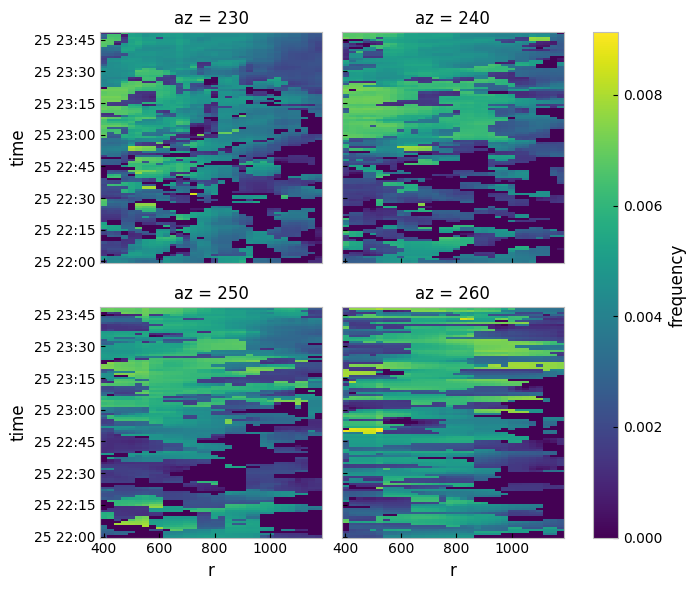

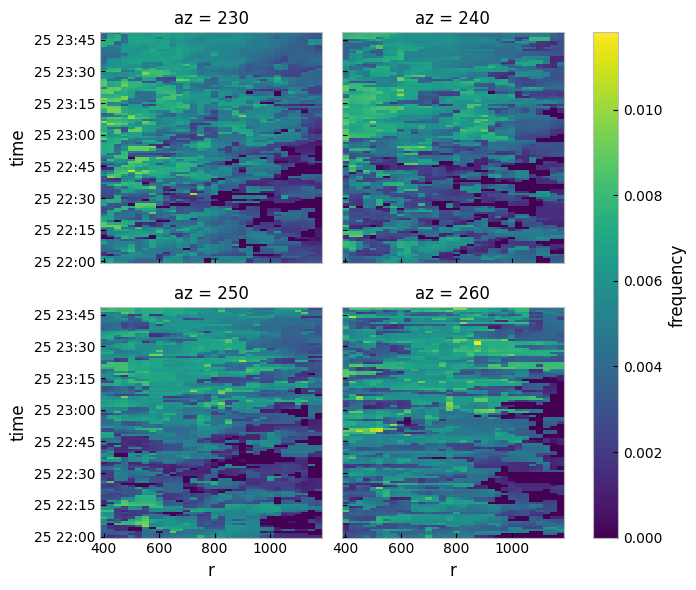

In [530]:
fig, ax = plt.subplots(3, 4, sharex=True, tight_layout=True, figsize=(12, 9))
for ii in range(len(tau.az)):
    tau.isel(az=ii).T.plot(ax=ax[0, ii], robust=True, add_colorbar=False, add_labels=False)
    wavelength.isel(az=ii).plot(ax=ax[1, ii], robust=True, add_colorbar=False, add_labels=False)
    phase_speed.isel(az=ii).plot(ax=ax[2, ii], robust=True, add_colorbar=False, add_labels=False)
    ax[0, ii].set_title(f"az={azimuth[ii]}")
    if ii != 0:
        ax[0, ii].set_yticklabels([])
        ax[1, ii].set_yticklabels([])
        ax[2, ii].set_yticklabels([])
ax[0, 0].set_ylabel("tau")
ax[1, 0].set_ylabel("wavelength")
ax[2, 0].set_ylabel("phase_speed")

max_comp.T.plot(col="az", col_wrap=2)
max_comp_x.plot(col="az", col_wrap=2)
max_comp_y.plot(col="az", col_wrap=2)

kx.plot(col="az", col_wrap=2)
ky.plot(col="az", col_wrap=2)
k.plot(col="az", col_wrap=2)


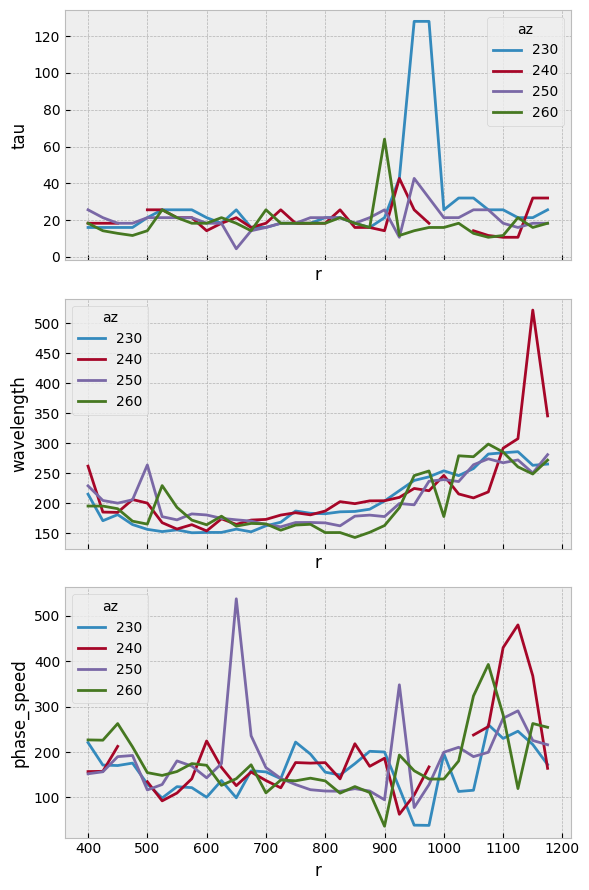

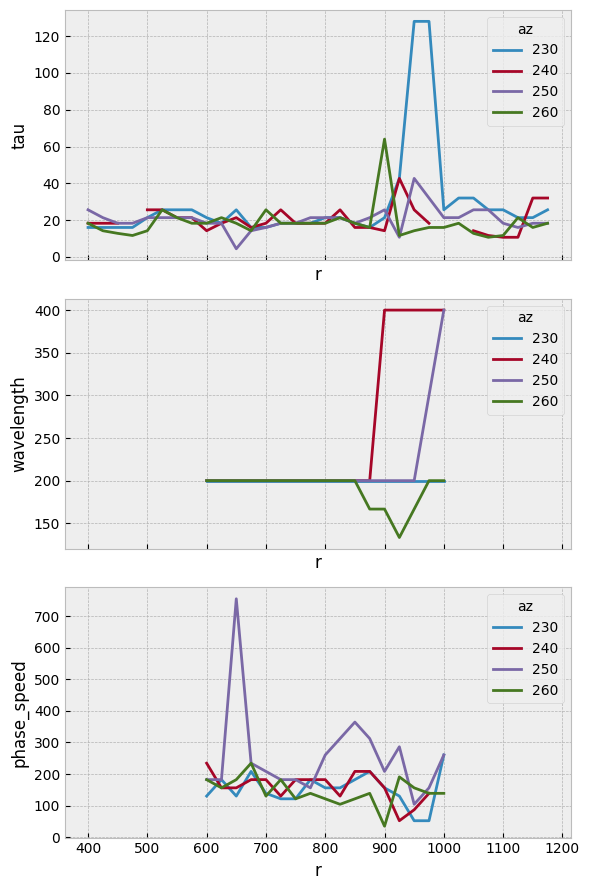

In [545]:
plt.style.use("bmh")
t1 = datetime(2015, 3, 25, 23, 30)
t2 = datetime(2015, 3, 25, 23, 45)
idt = (time >= t1) & (time <= t2)

fig, ax = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(6, 9))
tau.sel(time=slice(t1, t2)).median("time").plot(ax=ax[0], hue="az")
wavelength.sel(time=slice(t1, t2)).median("time").plot(ax=ax[1], hue="az")
phase_speed.sel(time=slice(t1, t2)).median("time").plot(ax=ax[2], hue="az")

fig, ax = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(6, 9))
tau.sel(time=slice(t1, t2)).median("time").plot(ax=ax[0], hue="az")
wavelength_r.sel(time=slice(t1, t2)).median("time").plot(ax=ax[1], hue="az")
phase_speed_r.sel(time=slice(t1, t2)).median("time").plot(ax=ax[2], hue="az")

In [ ]:
i = 75  # time index
im = data.image.values[i].copy()  # interpolated image
density = data.density.values[i]  # measurement density
isnan = density == 0
im[isnan] = np.nan

fig, ax = plt.subplots(2, 1, tight_layout=True, figsize=(16, 20))
ax[0].set_title(f'{time[i]}, Alt={data.height.values[i]}km')
ax[0].pcolormesh(x, y, im, cmap='gray', vmin=-.2, vmax=.2)
ax[0].plot(data.center.values[0], data.center.values[1], '.r')
for z in range(len(azimuth)):
    ax[0].plot(lines_x.isel(az=z), lines_y.isel(az=z))
    ax[1].plot(lines_tec.r, lines_tec.isel(time=i, az=z), label=f"{azimuth[z] =}")
ax[1].legend()
ax[0].set_xlabel('Longitude [km]')
ax[0].set_ylabel('Latitude [km]')
ax[1].set_xlabel('radius [km]')
ax[1].set_ylabel('TID amplitude')
vx = lines_x + v
vy = lines_y + v
ax[0].plot(vx.isel(az=z, r=slice(None, None, 6)), lines_y.isel(az=z, r=slice(None, None, 6)), 'r.')
ax[0].plot(lines_x.isel(az=z, r=slice(None, None, 6)), vy.isel(az=z, r=slice(None, None, 6)), 'b.')

In [106]:
# open file, pull out data
file = "outputs/2024-12-06/22-20-41/autofocus.h5"
data = xr.open_dataset(file)
time = data.time.values.astype('datetime64[s]').astype(datetime)
x = data.x.values  # x coordinate in local cartesian system (km)
y = data.y.values  # y coordinate in local cartesian system (km)
px = data.px.values  # x coordinate of patch center (km)
py = data.py.values  # y coordinate of patch center (km)
cx0, cy0 = data.center.values[0], data.center.values[1]  # TID center

# x0, y0 = -250, -300
azimuth = [230, 240, 250, 260]#, 280]
distance = np.arange(400,1200,25)

# create azimuth lines
for ia, az in enumerate(azimuth):
    if ia == 0:
        line = np.array([get_line_coordinates(cx0, cy0, azimuth, d) for d in distance])
    else:
        line = np.dstack((line, np.array([get_line_coordinates(cx0, cy0, azimuth, d) for d in distance])))

dist = np.arange(400, 1201, 50)
tau = np.nan * np.ones((time.size, len(azimuth), len(dist)))
lambh = np.nan * np.ones((time.size, len(azimuth), len(dist)))
ch = np.nan * np.ones((time.size, len(azimuth), len(dist)))
tid = np.nan * np.ones((time.size, len(azimuth), len(dist)))
lambh_az = np.nan * np.ones((time.size, len(azimuth)))
# iterate over azimuth lines
for ll in range(len(azimuth)):
    # iterate radii along azimuth lines
    for ixx, d in enumerate(dist):
        # get x and y coordinates of point
        idd = abs(distance - d).argmin()
        x0, y0 = np.round(line[idd, :, ll], 1)
        # get indices into image
        idx, idy = abs(x - x0).argmin(), abs(y - y0).argmin()
        # Set up slices
        dx = np.round(np.nanmedian(np.diff(x)))  # pixel spacing
        L = 800  # estimation distance km
        Ndx = round(L / 2 / dx)  # estimation distance pix
        # median image value around point
        tid_center = np.nanmedian(data.image.values[:, idy-2:idy+2, idx-2:idx+2], axis=(1,2))
        tid[:, ll, ixx] = tid_center
        # median image value around line y=y_point
        tid_zonal = np.nanmedian(data.image.values[:, idy-2:idy+2, idx-Ndx:idx+Ndx], axis=1)
        # median image value around line x=x_point ??? NOTE: should this be axis=2 ??
        # tid_meridional = np.nanmedian(data.image.values[:, idy-Ndx:idy+Ndx, idx-2:idx+2], axis=1)
        tid_meridional = np.nanmedian(data.image.values[:, idy-Ndx:idy+Ndx, idx-2:idx+2], axis=2)

        # Estimate Period
        # gets spectrogram (short time Fourier transform)
        F_period, Stt = tdftt(time, tid_center, T=60, nfft=128, Nw=30, Nskip=1)
        period_th = 0.0001
        # frequency component with max power at each time
        period_max = np.nanargmax(np.nan_to_num(Stt), axis=1)
        period_max[np.nanmax(np.nan_to_num(Stt), axis=1) <= period_th] = 0
        f_r = F_period[period_max]
        f_r[f_r == 0] = np.nan  # zero out DC components
        # compute period in minutes
        tau_r = 1 / f_r
        tau[:, ll, ixx] = tau_r / 60
        
        # Estimate Wavenumber
        nfft = 1024
        kx_spectra = np.nan * np.zeros((time.size, int(nfft/2)))
        ky_spectra = np.nan * np.zeros((time.size, int(nfft/2)))
        
        for i in range(1, time.size-1):
            try:
                kx, kx_spectra[i, :] = tdft(np.nanmedian(tid_zonal[i - 1 : i + 1, :], axis=0), dx, nfft=nfft)
            except:
                pass
            try:
                ky, ky_spectra[i, :] = tdft(np.nanmedian(tid_meridional[i - 1 : i + 1, :], axis=0), dx, nfft=nfft)
            except:
                pass
        kx_th = 0.0001
        ky_th = 0.0001
        kx_max = np.nanargmax(np.nan_to_num(kx_spectra), axis=1)
        kx_max[np.nanmax(np.nan_to_num(kx_spectra), axis=1) <= kx_th] = 0
        #kx_max[kx_max <= 2] = 0
        
        ky_max = np.nanargmax(np.nan_to_num(ky_spectra), axis=1)
        ky_max[np.nanmax(np.nan_to_num(ky_spectra), axis=1) <= ky_th] = 0
        #ky_max[kx_max <= 2] = 0
        
        lambda_h = np.nan * np.ones(time.size).astype(np.float32)
        lambda_x = np.nan * np.ones(time.size).astype(np.float32)
        lambda_y = np.nan * np.ones(time.size).astype(np.float32)
        c_x = np.nan * np.ones(time.size).astype(np.float32)
        c_y = np.nan * np.ones(time.size).astype(np.float32)
        c_h = np.nan * np.ones(time.size).astype(np.float32)
        theta = np.nan * np.ones(time.size).astype(np.float32)
        
        # for i in range(time.size):
        #     if kx_max[i] >= 0 and ky_max[i] >= 0:
        #         lambda_x[i] = 1 / kx[kx_max[i]]
        #         lambda_y[i] = 1 / ky[ky_max[i]]
        #         if lambda_y[i] < L or lambda_x[i] < L:
        #             lambda_h[i] = 1 / np.sqrt(1/lambda_x[i]**2 +  1/lambda_y[i]**2)
        for i in range(time.size):
            if kx_max[i] > 0 and ky_max[i] > 0:
                kxy = (kx[kx_max[i]], ky[ky_max[i]])
                lambda_x[i] = 1 / kxy[0]
                lambda_y[i] = 1 / kxy[1]
                if lambda_y[i] < L or lambda_x[i] < L:
                    lambda_h[i] = 1 / np.hypot(*kxy)
        
        l_h = np.asanyarray(pd.Series(lambda_h).rolling(10, min_periods=4, center=True).median())
        l_x = np.asanyarray(pd.Series(lambda_x).rolling(10, min_periods=4, center=True).median())
        l_y = np.asanyarray(pd.Series(lambda_y).rolling(10, min_periods=4, center=True).median())
        l_h_std = np.asanyarray(pd.Series(lambda_h).rolling(10, min_periods=4, center=True).std())
        for i in range(time.size):
            if np.isfinite(l_h[i]) and period_max[i] > 0:
                c_x[i] = l_x[i] * 1000 / tau_r[i]
                c_y[i] = l_y[i] * 1000 / tau_r[i]
                if np.isfinite(c_x[i]) and np.isfinite(c_y[i]):
                    c_h[i] = np.hypot(c_x[i], c_y[i])
                elif np.isfinite(c_x[i]):
                    c_h[i] = c_x[i]
                elif np.isfinite(c_y[i]):
                    c_h[i] = c_y[i]
                else:
                    pass
                theta[i] = np.degrees(np.arctan2(c_y[i], c_x[i]))
        # for i in range(time.size):
        #     if np.isfinite(l_h[i]) and period_max[i] > 0:
        #         c_x[i] = l_x[i]*1e3 / (tau_r[i])
        #         c_y[i] = l_y[i]*1e3 / (tau_r[i])
        #         if np.logical_and(np.isfinite(c_x[i]), np.isfinite(c_y[i])):
        #             c_h[i] = 1 / np.sqrt((1 / c_x[i]) ** 2 + (1 / c_y[i]) ** 2)
        #         elif np.logical_or(np.isfinite(c_x[i]), np.isfinite(c_y[i])):
        #             c_h[i] = 1 / np.sqrt(1/c_x[i])**2 if np.isfinite(c_x[i]) else 1 / np.sqrt(1/c_y[i])**2
        #         else:
        #             pass
        #         theta[i] = np.degrees(np.arctan2(c_y[i], c_x[i]))
        lambh[:, ll, ixx] = l_h
        ch[:, ll, ixx] = c_h

/tmp/ipykernel_527/2448153850.py:49: RuntimeWarning: All-NaN slice encountered
  plt.plot(dist, np.nanmedian(tau[idt, zz, :], axis=0), '.-', label=f'{azm}deg')
/tmp/ipykernel_527/2448153850.py:58: RuntimeWarning: All-NaN slice encountered
  plt.plot(dist, np.nanmedian(ch[idt, zz, :], axis=0), '.-', label=f'{azm}deg')
/tmp/ipykernel_527/2448153850.py:67: RuntimeWarning: All-NaN slice encountered
  plt.plot(dist, np.nanmedian(lambh[idt, zz, :], axis=0), '.-', label=f'{azm}deg')


Text(0, 0.5, 'Horizontal Wavelength [km]')

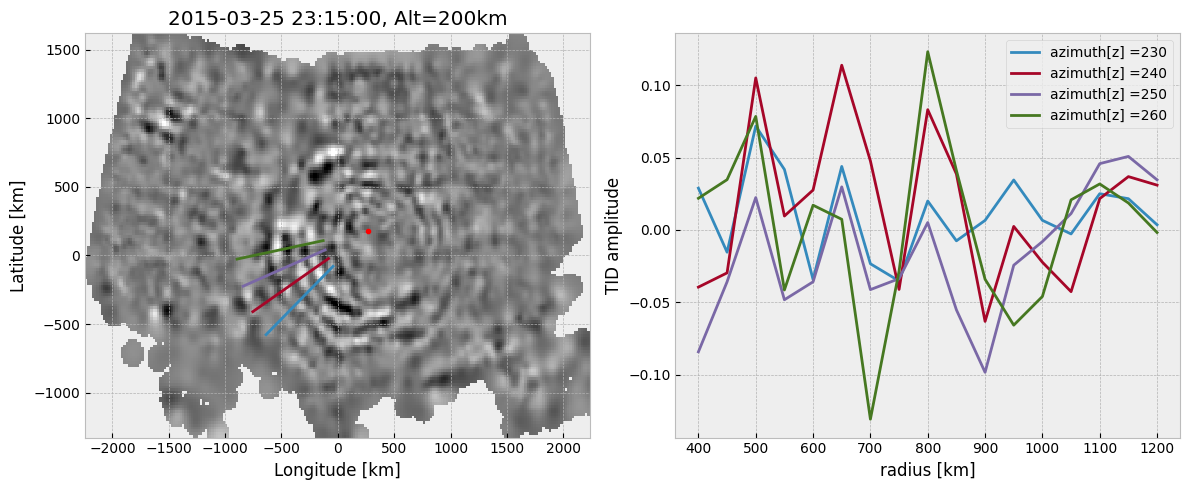

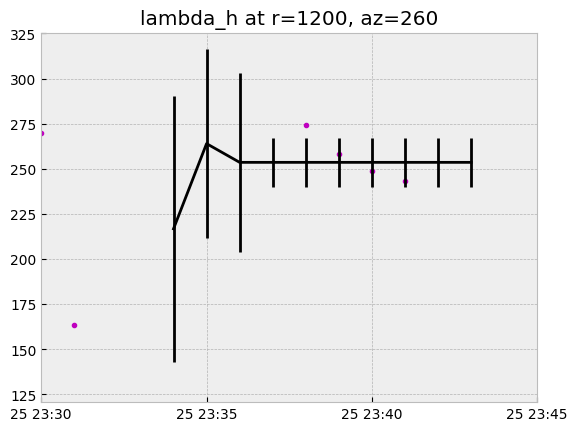

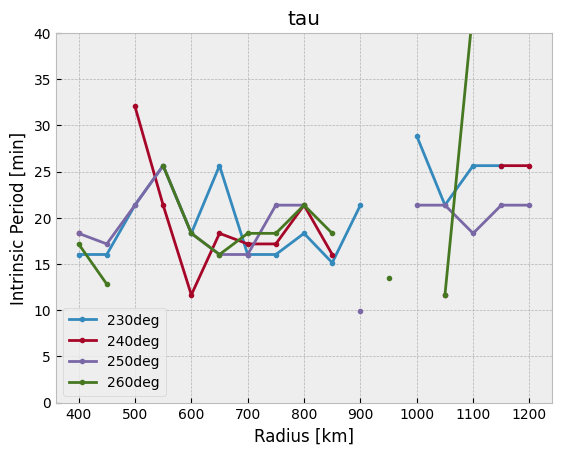

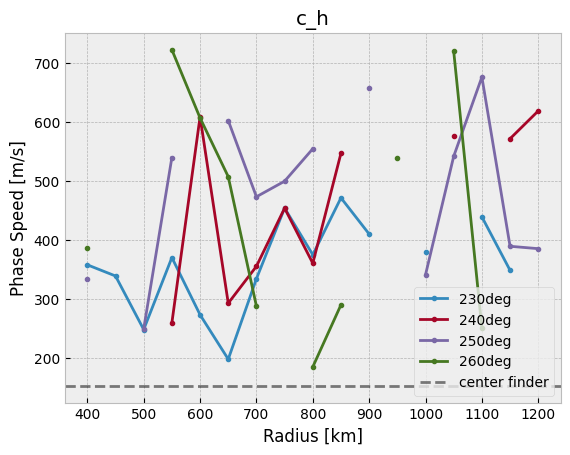

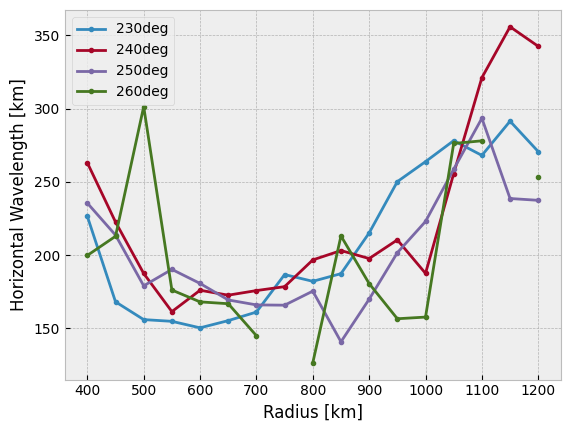

In [53]:
i = 75  # time index
im = data.image.values[i]  # interpolated image
density = data.density.values[i]  # measurement density
isnan = density == 0
im[isnan] = np.nan

fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))
ax[0].set_title(f'{time[i]}, Alt={data.height.values[i]}km')
ax[0].pcolormesh(x, y, im, cmap='gray', vmin=-.2, vmax=.2)
ax[0].plot(data.center.values[0], data.center.values[1], '.r')
for z in range(len(azimuth)):
    ax[0].plot(line[:, 0, z], line[:, 1, z])
    ax[1].plot(dist, tid[i, z], label=f"{azimuth[z] =}")
ax[1].legend()
ax[0].set_xlabel('Longitude [km]')
ax[0].set_ylabel('Latitude [km]')
ax[1].set_xlabel('radius [km]')
ax[1].set_ylabel('TID amplitude')

# fig = plt.figure()
# plt.pcolormesh(time, kx, kx_spectra.T, cmap='nipy_spectral', vmin = 0.00001, vmax = 0.005)
# plt.plot(time, kx[kx_max], 'b')

# fig = plt.figure()
# plt.pcolormesh(time, ky, ky_spectra.T, cmap='nipy_spectral', vmin = 0.00001, vmax = 0.001)
# plt.plot(time, ky[ky_max], 'b')

t1 = datetime(2015, 3, 25, 23, 30)
t2 = datetime(2015, 3, 25, 23, 45)
idt = (time >= t1) & (time <= t2)

c = data.offset
c = c.max() - c
c *= 1000
diff = c.differentiate("time", datetime_unit="s")
ch_cf = diff.sel(time=slice(t1, t2)).mean()

tlim = [t1, t2]
fig = plt.figure()
plt.title(f"lambda_h at r={d}, az={azimuth[ll]}")
plt.plot(time, lambda_h, '.m')
plt.errorbar(time, l_h, yerr=l_h_std, c='k')
plt.xlim(tlim)

# average in this time for angles around 210
plt.figure()
plt.title("tau")
for zz, azm in enumerate(azimuth):
    plt.plot(dist, np.nanmedian(tau[idt, zz, :], axis=0), '.-', label=f'{azm}deg')
plt.legend()
plt.xlabel('Radius [km]')
plt.ylabel('Intrinsic Period [min]')
plt.ylim(0, 40)

plt.figure()
plt.title("c_h")
for zz, azm in enumerate(azimuth):
    plt.plot(dist, np.nanmedian(ch[idt, zz, :], axis=0), '.-', label=f'{azm}deg')
plt.axhline(ch_cf, linestyle="--", color="k", alpha=.5, label="center finder")
plt.legend()
plt.xlabel('Radius [km]')
plt.ylabel('Phase Speed [m/s]')


plt.figure()
for zz, azm in enumerate(azimuth):
    plt.plot(dist, np.nanmedian(lambh[idt, zz, :], axis=0), '.-', label=f'{azm}deg')
    # plt.plot(dist, np.nanmedian(ch[idt,zz,:], axis=0))
plt.legend()
plt.xlabel('Radius [km]')
plt.ylabel('Horizontal Wavelength [km]')

/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xrscipy/signal/spectral.py:308: UserWarning: nperseg = 256 is greater than input length  = 41, using nperseg = 41
  f, t, Pxy = _spectral_helper(
/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xrscipy/signal/spectral.py:308: UserWarning: nperseg = 256 is greater than input length  = 41, using nperseg = 41
  f, t, Pxy = _spectral_helper(


MergeError: conflicting values for variable 'x' on objects to be combined. You can skip this check by specifying compat='override'.

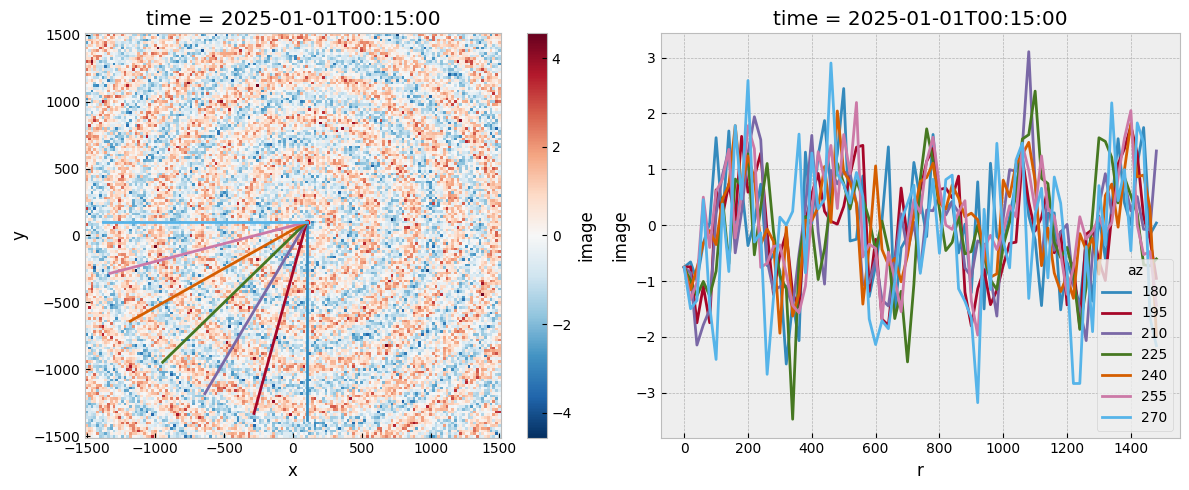

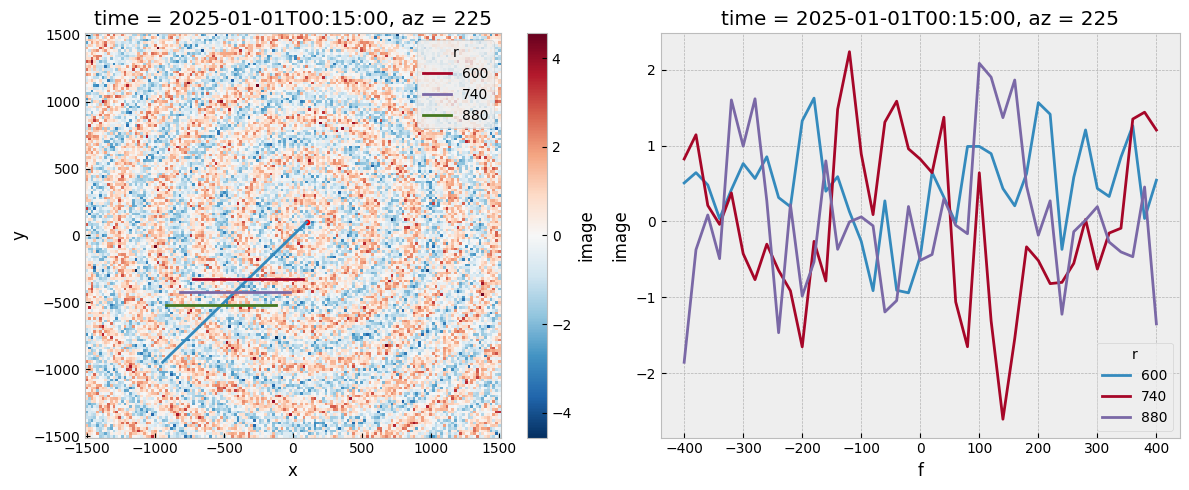

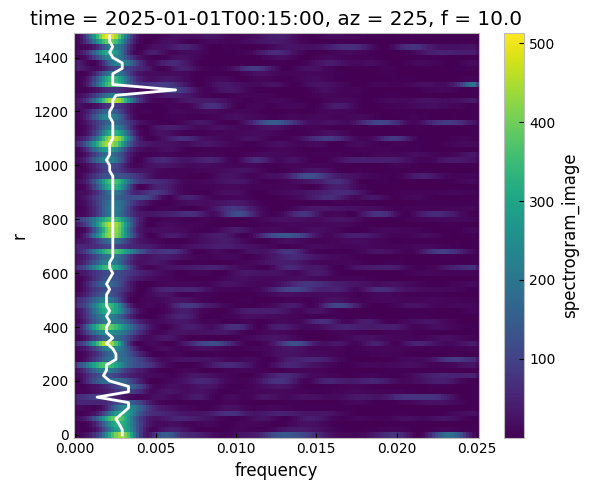

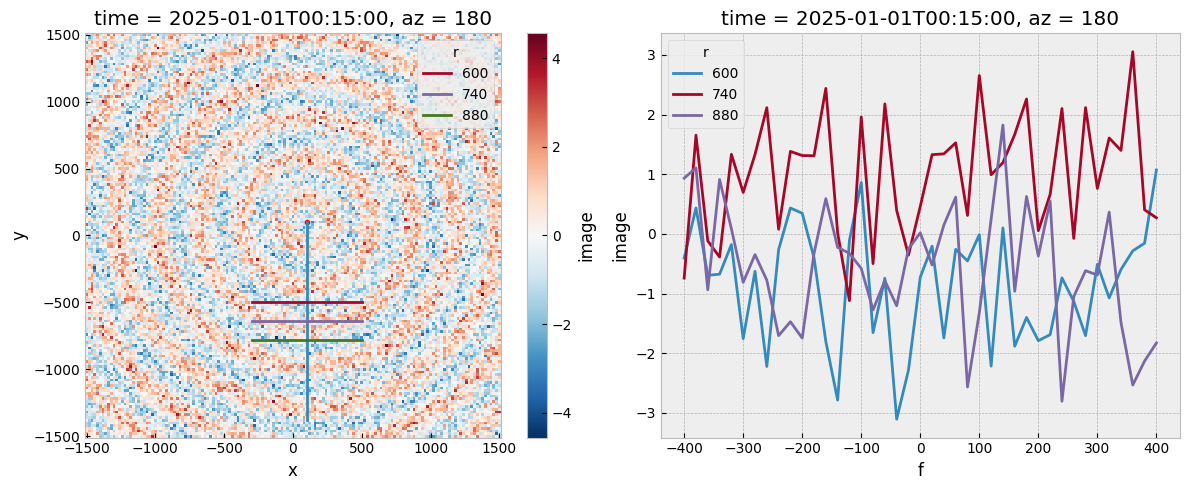

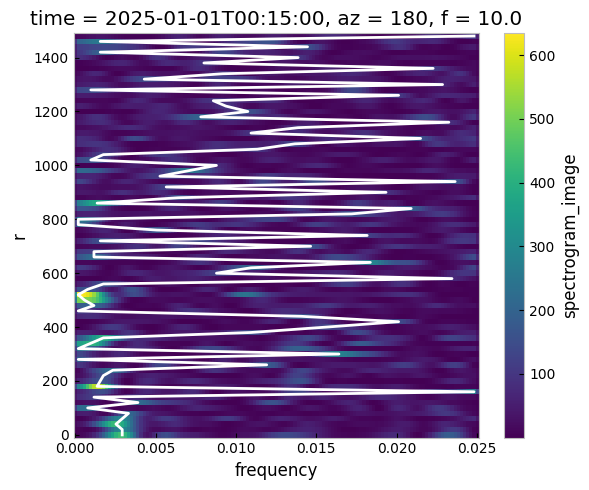

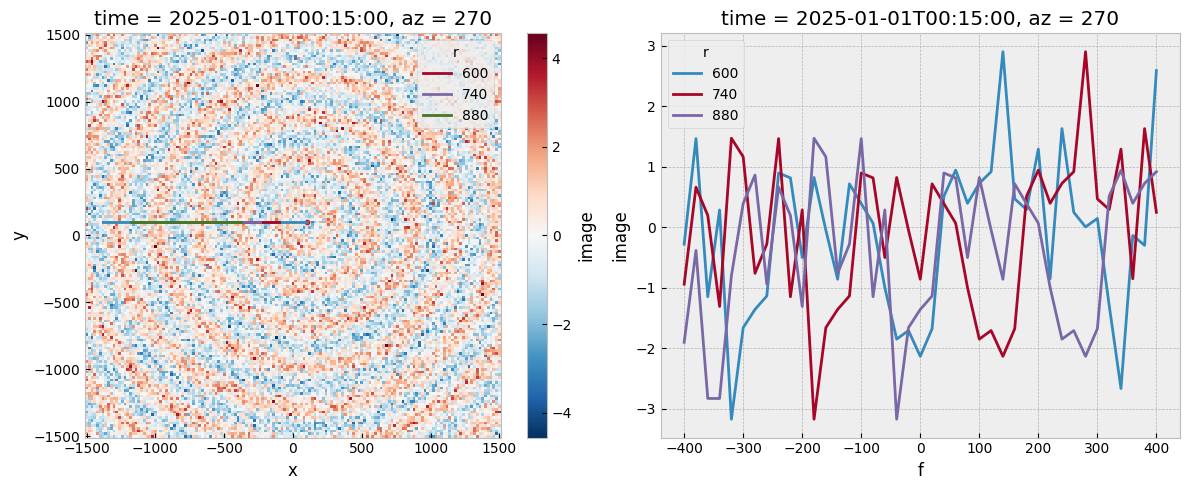

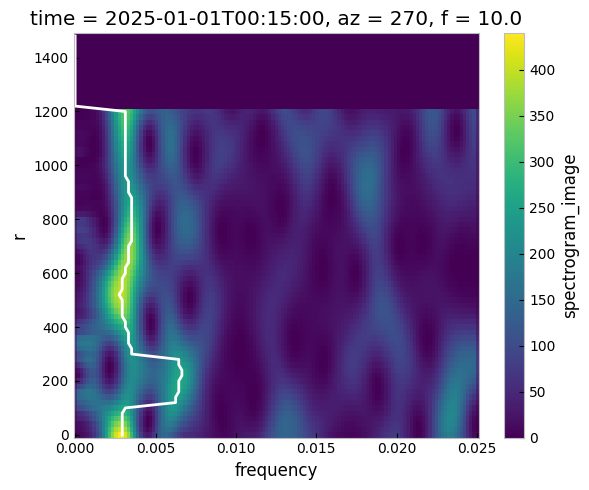

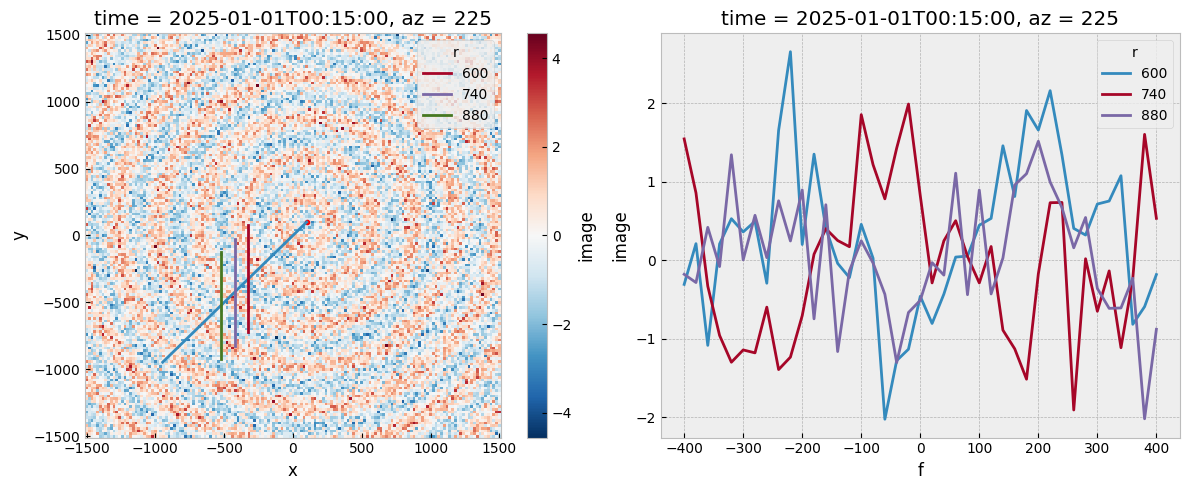

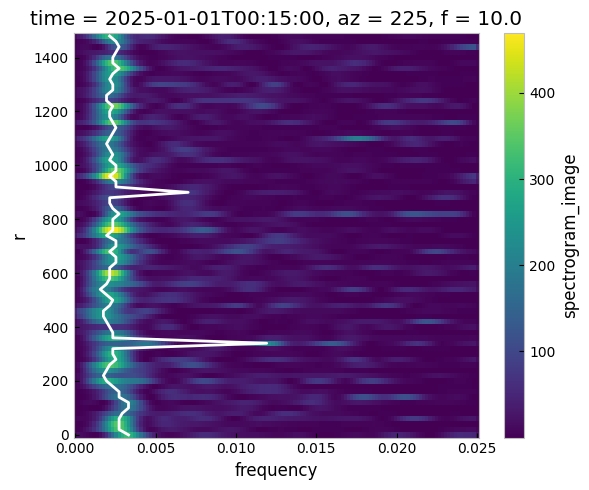

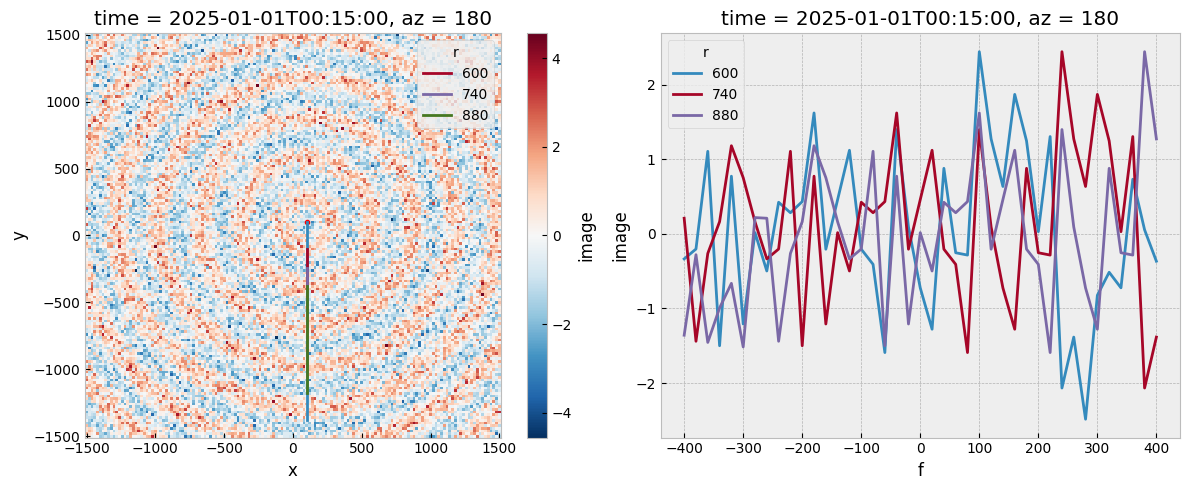

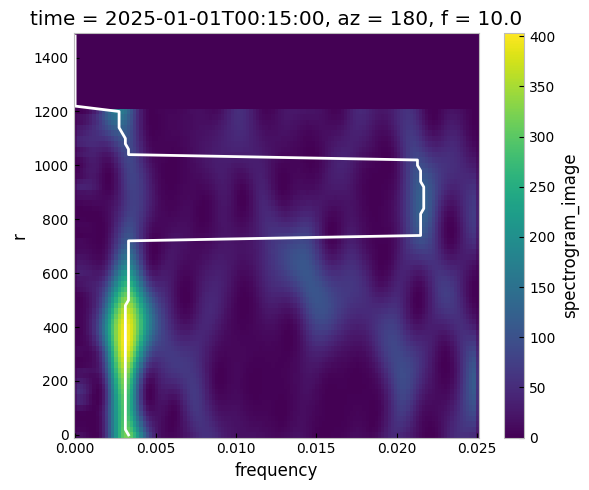

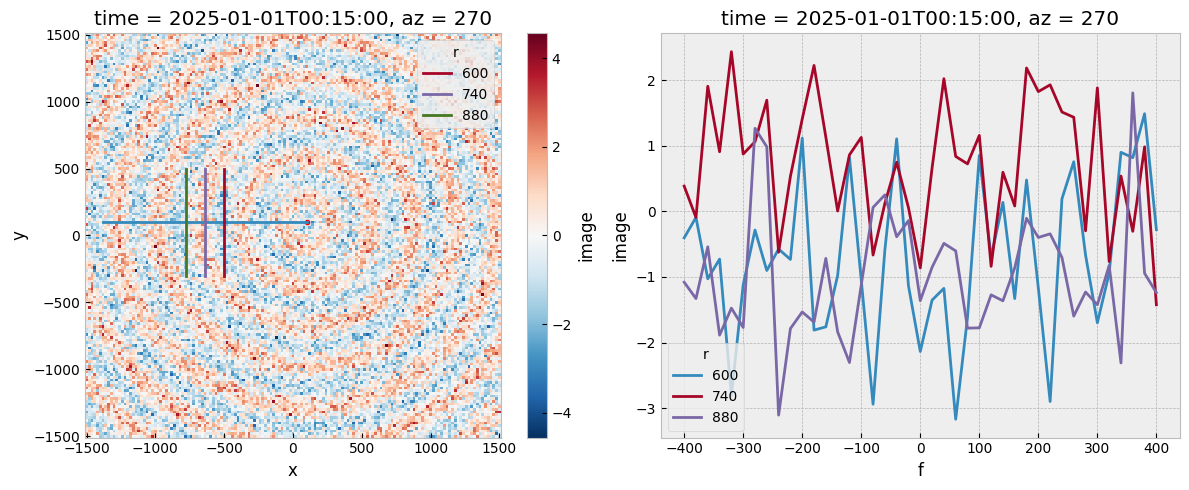

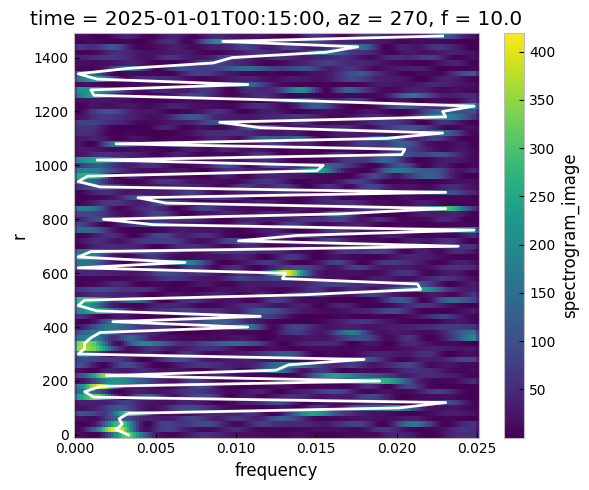

In [18]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import xarray
plt.style.use("bmh")

import gnss_tid.synthetic
import gnss_tid.parameter

center = xarray.DataArray([100, 100], dims=["ci"])
wavelength = 300.0
phase_speed = 200.0

image = gnss_tid.synthetic.constant_model(
    center=center,
    wavelength=wavelength,
    phase_speed=phase_speed,
    xlim=(-1500, 1500),
    ylim=(-1500, 1500),
    snr=-3,
)
data = xarray.Dataset({"image": image, "center": center})
params = gnss_tid.parameter.estimate_parameters(data, np.arange(0, 1500, 20), np.arange(180, 280, 15))
# plt.figure()
# data.image.isel(time=15).plot()
# plt.plot(data.center.values[0], data.center.values[1], '.r')
# for z in range(len(params.az)):
#     plt.plot(params.x.isel(az=z), params.y.isel(az=z))

# plt.figure()
# params.tec.isel(az=0).plot()

# fig, ax = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(6, 9))
# params.tau.isel(time=slice(15, 30)).median("time").plot(ax=ax[0], hue="az")
# ax[0].axhline((1000 * wavelength / phase_speed) / 60, linestyle="--", color="k", alpha=.5)
# params.wavelength.isel(time=slice(15, 30)).median("time").plot(ax=ax[1], hue="az")
# ax[1].axhline(wavelength, linestyle="--", color="k", alpha=.5)
# params.phase_speed.isel(time=slice(15, 30)).median("time").plot(ax=ax[2], hue="az")
# ax[2].axhline(phase_speed, linestyle="--", color="k", alpha=.5)

# file = "outputs/2024-12-06/22-20-41/autofocus.h5"
# data = xarray.open_dataset(file)
# params = gnss_tid.parameter.estimate_parameters(data, np.arange(0, 1500, 10), np.arange(180, 280, 10))
# t1 = datetime(2015, 3, 25, 23, 20)
# fig, ax = plt.subplots(3, 1, sharex=True, tight_layout=True, figsize=(6, 9))
# params.tau.sel(time=slice(t1, t2)).median("time").plot(ax=ax[0], hue="az")
# params.wavelength.sel(time=slice(t1, None)).median("time").plot(ax=ax[1], hue="az")
# params.phase_speed.sel(time=slice(t1, None)).median("time").plot(ax=ax[2], hue="az")

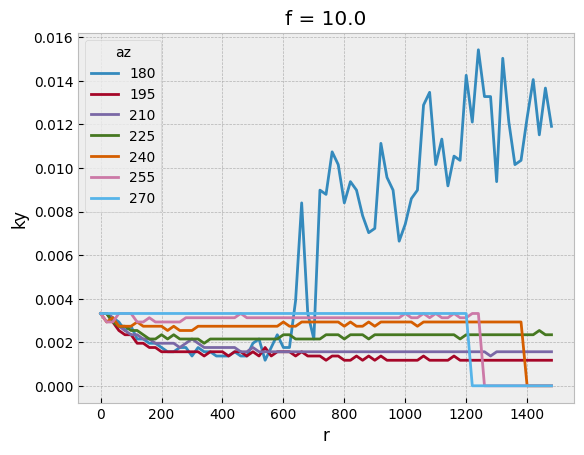

In [16]:
# params.phase_speed.median("time").plot(hue="az")
# params.k.median("time").plot(hue="az")
# params.wavelength.median("time").plot(hue="az")
params.ky.median("time").plot(hue="az")

nearest


/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xrscipy/signal/spectral.py:308: UserWarning: nperseg = 256 is greater than input length  = 41, using nperseg = 41
  f, t, Pxy = _spectral_helper(


linear


/homes/starrgw1/code/gnss-tid/.venv/lib/python3.11/site-packages/xrscipy/signal/spectral.py:308: UserWarning: nperseg = 256 is greater than input length  = 41, using nperseg = 41
  f, t, Pxy = _spectral_helper(


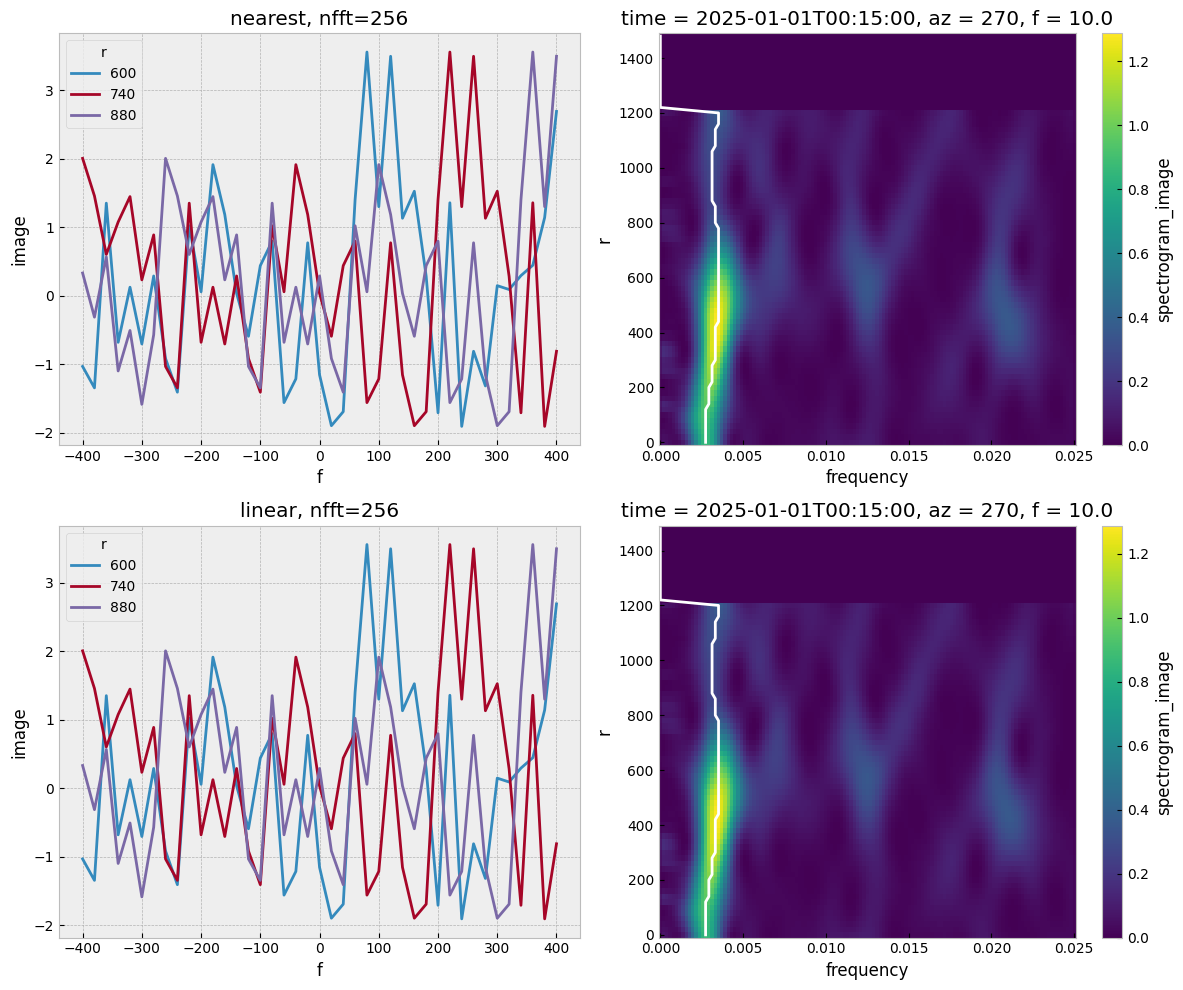

In [38]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from xrscipy.signal import spectrogram
plt.style.use("bmh")

import gnss_tid.synthetic
import gnss_tid.parameter
import gnss_tid.plotting

center = xr.DataArray([100, 100], dims=["ci"])
wavelength = 300.0
phase_speed = 200.0

image = gnss_tid.synthetic.constant_model(
    center=center,
    wavelength=wavelength,
    phase_speed=phase_speed,
    xlim=(-1500, 1500),
    ylim=(-1500, 1500),
    snr=-3,
)
data = xr.Dataset({"image": image, "center": center})
range_coords = np.arange(0, 1500, 20)
az_coords = np.arange(180, 280, 15)

cx0, cy0 = data.center.values[0], data.center.values[1]  # TID center
lines_x, lines_y = gnss_tid.parameter.get_line_coordinates(cx0, cy0, az_coords, range_coords)
lines_x = xr.DataArray(
    lines_x, coords={"r": range_coords, "az": az_coords}, dims=["r", "az"]
)
lines_y = xr.DataArray(
    lines_y, coords={"r": range_coords, "az": az_coords}, dims=["r", "az"]
)
lines_tec = data.image.interp(x=lines_x, y=lines_y)

L = 800
dx = (data.x[1] - data.x[0]).item()
v = np.arange(-(L / 2), (L / 2) + dx / 2, dx)
v = xr.DataArray(v, coords={"f": v}, dims=["f"])

fig, ax = plt.subplots(2, 2, tight_layout=True, figsize=(12, 10))

Nfft = 256
for ii, method in enumerate(["nearest", "linear"]):
    print(method)
    tec_zonal = data.image.interp(x=lines_x + v, y=lines_y, method=method)
    Sx = spectrogram(tec_zonal, dim="f", noverlap=0, nfft=Nfft, nperseg=Nfft, scaling="spectrum").isel(f=0)
    # Sx = abs(rfft(tec_zonal, "f", n=Nfft)) ** 2
    Sx = Sx.fillna(0)

    r_idx = tec_zonal.r.shape[0] // 2
    dr = tec_zonal.r.shape[0] // 10
    r_idx = [r_idx - dr, r_idx, r_idx + dr]
    t = tec_zonal.isel(time=15, az=-1)
    t.isel(r=r_idx).plot(ax=ax[ii, 0], x="f", hue="r")
    gnss_tid.plotting.plot_param_spatial_fft(Sx, az_idx=-1, ax=ax[ii, 1])
    ax[ii, 0].set_title(f"{method}, nfft={Nfft}")